# Twitter Sentiment Analysis.

## Business Problem.

We want to analyze a COVID-19 Twitter dataset to understand how positive and negative trends spread after news announcements.

Key Questions:

How do positive and negative sentiments spread among users after a news announcement related to COVID-19?

Purpose:

Help media outlets measure the impact of their announcements on public sentiment.

Goals:

Track sentiment trends over time.


## Dataset location and download instructions.

[Covid-19 Twitter Dataset](https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset/data)


* Place datasets into ```Data``` folder if running the notebook locally.
* Upload the files into ```/content``` root file folder of Colab environment.

## Installing the required modules.

We'll start with installing the requirements [available here](https://github.com/leksea/capstone-twitter-sentiment-analysis/blob/main/requirements.txt).

In [62]:
!wget https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt
!pip install -r 'requirements.txt'

--2024-12-27 22:45:17--  https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     114  --.-KB/s    in 0s      

2024-12-27 22:45:17 (6.08 MB/s) - ‘requirements.txt’ saved [114/114]



### Importing modules.

In [63]:
# built-in modules
import os
import string
import re
import glob
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
# progress bar monitoring
from tqdm import tqdm
# data manupulation, analysis
import numpy as np
import pandas as pd
# general data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# world maps
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#for location standartization
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
# world cloud
from wordcloud import WordCloud
# Natural Language Processing (NLP)
import nltk
from emot.emo_unicode import UNICODE_EMOJI
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline
# stop words for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading The Covid-19 Twitter Datasets.

In [64]:
# Supplemental function to determine data directory
# Input: none
# Output: Data directory, depending on runtime environment.

def determine_data_dir():
    """
    Determines the data directory based on the execution environment:
    - Local: Uses 'Data' directory in the current working directory.
    - Cloud (e.g., Google Colab): Uses '/content' as the data directory.

    Returns:
        str: Path to the appropriate data directory.
    """
    if 'COLAB_GPU' in os.environ:  # Check if running in Google Colab
        data_dir = "/content"
        print(f"Running in Google Colab. Using data directory: {data_dir}")
    else:
        data_dir = os.path.join(os.getcwd(), "Data")
        print(f"Running locally. Using data directory: {data_dir}")

        # Ensure the 'Data' directory exists locally
        if not os.path.isdir(data_dir):
            print(f"The directory '{data_dir}' does not exist. Please create it and place the data files there.")
            raise FileNotFoundError(f"'{data_dir}' directory is required for local execution.")

    return data_dir

In [65]:
# Loading the files
# Determine the data directory
data_dir = determine_data_dir()

# Step 1: Locate all CSV files in the determined directory
files_pattern = os.path.join(data_dir, "*.csv")
files = glob.glob(files_pattern)

# Step 2: Check if files are found
if not files:
    print(f"No CSV files found in directory: {data_dir}")
else:
     # Step 3: Load and inspect each file
    dfs = []  # Store valid DataFrames
    for file in files:
        try:
            # Load the DataFrame
            df = pd.read_csv(file)
            rows, cols = df.shape
            print(f"File: {file} | Rows: {rows}, Columns: {cols}")

            # Optional: Skip empty files or files with no columns
            if rows == 0 or cols == 0:
                print(f"Skipping empty or invalid file: {file}")
                continue

            # Append to list if valid
            dfs.append(df)

        except Exception as e:
            print(f"Error loading file {file}: {e}")

    # Step 4: Concatenate all valid DataFrames
    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
        print(data.head())
    else:
        print("No valid DataFrames to concatenate.")

Running in Google Colab. Using data directory: /content
File: /content/Covid-19 Twitter Dataset (Aug-Sep 2020).csv | Rows: 120509, Columns: 17
File: /content/Covid-19 Twitter Dataset (Apr-Jun 2020).csv | Rows: 143903, Columns: 17
File: /content/Covid-19 Twitter Dataset (Apr-Jun 2021).csv | Rows: 147475, Columns: 17
Data loaded successfully with 411887 rows and 17 columns.
             id  created_at  \
0  1.300000e+18  2020-08-20   
1  1.300000e+18  2020-08-20   
2  1.300000e+18  2020-08-20   
3  1.300000e+18  2020-08-20   
4  1.300000e+18  2020-08-20   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twitter.com/download/android" ...   
3  <a href="https://about.twitter.com/products/tw...   
4  <a href="http://twitter.com/download/android" ...   

                                       original_text lang  favorite_count  \
0  RT @RobertAlai: 91-ye

## Exploratory Data Analysis.
### Data Understanding and Cleaning.

We'll start with getting general information about the dataset and identify the columns of interest.

In [66]:
# get general info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411887 entries, 0 to 411886
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               411883 non-null  float64
 1   created_at       411885 non-null  object 
 2   source           411587 non-null  object 
 3   original_text    411885 non-null  object 
 4   lang             411884 non-null  object 
 5   favorite_count   411884 non-null  float64
 6   retweet_count    411884 non-null  float64
 7   original_author  411884 non-null  object 
 8   hashtags         97775 non-null   object 
 9   user_mentions    295207 non-null  object 
 10  place            293775 non-null  object 
 11  clean_tweet      409915 non-null  object 
 12  compound         411887 non-null  float64
 13  neg              411887 non-null  float64
 14  neu              411887 non-null  float64
 15  pos              411887 non-null  float64
 16  sentiment        411887 non-null  obje

In [67]:
# info about the numeric columns
data.describe()

,id,favorite_count,retweet_count,compound,neg,neu,pos
count,4.118830e+05,411884.000000,411884.000000,411887.000000,411887.000000,411887.000000,411887.000000
mean,1.324197e+18,0.216726,1585.174163,0.008415,0.090920,0.807021,0.102052
std,5.902218e+16,6.332250,9423.896052,0.370853,0.152717,0.200474,0.157080
min,1.250000e+18,0.000000,0.000000,-0.992500,0.000000,0.000000,0.000000
25%,1.260000e+18,0.000000,1.000000,-0.102700,0.000000,0.667000,0.000000
50%,1.310000e+18,0.000000,15.000000,0.000000,0.000000,0.819000,0.000000
75%,1.395011e+18,0.000000,243.000000,0.226300,0.180000,1.000000,0.200000
max,1.409140e+18,2923.000000,416923.000000,0.980500,1.000000,1.000000,1.000000


In [68]:
# select subset of tweets we'll be working with:
cols_to_keep = ['id', 'created_at', 'original_text', \
                'lang', 'favorite_count', 'retweet_count', 'original_author', \
                'hashtags', 'user_mentions', 'place', 'neg', 'neu', 'pos']
tweets_df = data[cols_to_keep].copy()

In [69]:
# Supplemental function will display unique values for all categorical columns in a dataframe.
def display_categorical_vals(df):
    # select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # print categorical columns and their unique values
    for col in categorical_columns:
        unique_values = df[col].unique()
        print(f"Column '{col}' has unique values: {unique_values}")

In [70]:
display_categorical_vals(tweets_df)

Column 'created_at' has unique values: ['2020-08-20' '2020-08-21' '2020-08-22' '2020-08-23' '2020-08-24'
 '2020-08-26' '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31'
 '2020-09-01' '2020-09-02' '2020-09-03' '2020-09-06' '2020-09-12'
 '2020-09-13' '2020-09-15' '2020-09-17' '2020-09-19' '2020-09-20'
 '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25' '2020-09-26'
 '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30' '2020-10-01'
 '2020-10-02' '2020-10-03' '2020-10-04' nan '2020-10-05' '2020-10-06'
 '2020-10-07' '2020-10-08' '2020-10-09' '2020-10-10' '2020-10-11'
 '2020-10-12' '2020-10-13' '2020-10-14' '2020-10-15' '2020-10-16'
 '2020-10-17' '2020-10-18' '2020-10-19' '2020-10-20' '2020-04-19'
 '2020-04-22' '2020-04-23' '2020-04-24' '2020-04-25' '2020-04-26'
 '2020-04-27' '2020-04-28' '2020-04-29' '2020-04-30' '2020-05-01'
 '2020-05-02' '2020-05-03' '2020-05-04' '2020-05-05' '2020-05-06'
 '2020-05-07' '2020-05-08' '2020-05-09' '2020-05-10' '2020-05-11'
 '2020-05-12' '2020-05-13' '2020-

### Data Type Conversion.

In [71]:
#rename date column for clarity and convert to date
tweet_df = data.rename(columns={'created_at': 'date'})
tweet_df['date'] = pd.to_datetime(tweet_df['date'])

Follow by exploratory data analysis:
* What were daily tweet patters?
* What were the top 20 days with most tweets?  

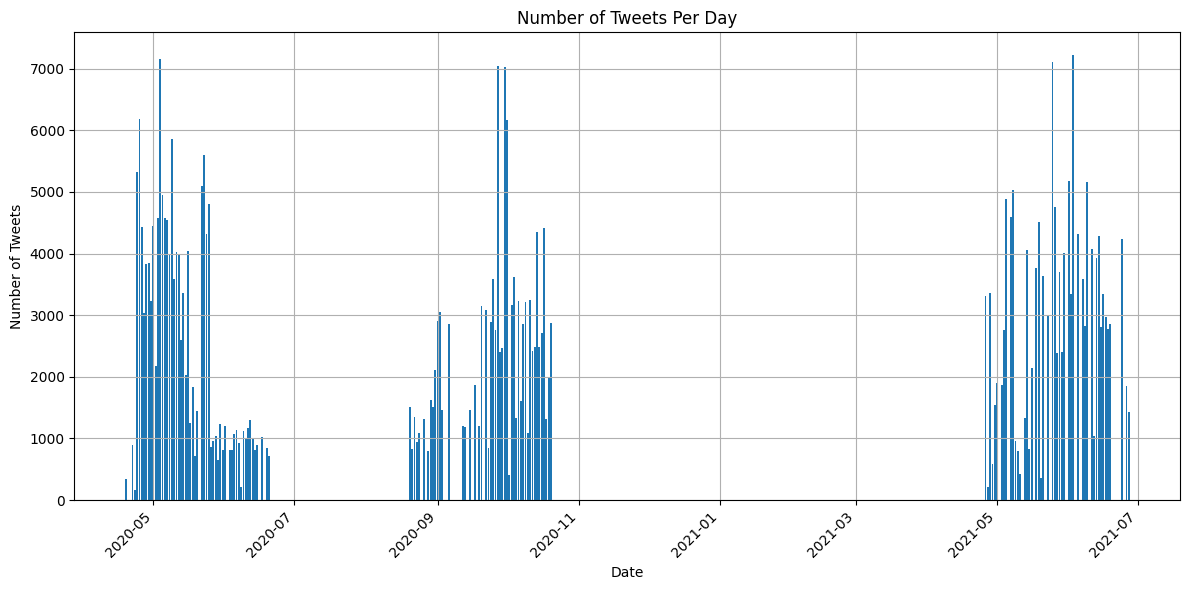

In [72]:
# exploratory analysis: plot number of tweets per day
# group by date and count tweets
tweets_per_day = tweet_df.groupby(tweet_df['date'].dt.date)['id'].count()

plt.figure(figsize=(12, 6))
plt.bar(tweets_per_day.index, tweets_per_day.values)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets Per Day")
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [73]:
# exploratory analysis: list the top 20 days with the most tweets
# rename columns for clarity
tweets_per_day.columns = ['date', 'tweet_count']

# sort by tweet count and get the top 20
top_20_days = tweets_per_day.sort_values(ascending=False).head(20)

# display the result
print(top_20_days)

date
2021-06-03    7229
2020-05-04    7165
2021-05-25    7114
2020-09-27    7040
2020-09-30    7028
2020-04-25    6178
2020-10-01    6166
2020-05-09    5857
2020-05-23    5600
2020-04-24    5323
2021-06-01    5175
2021-06-09    5158
2020-05-22    5102
2021-05-08    5032
2020-05-05    4949
2021-05-05    4886
2020-05-25    4804
2021-05-26    4750
2021-05-07    4586
2020-05-06    4575
Name: id, dtype: int64


### Evaluating and Handling Missing Values.
Before coming up with the strategy for each column, we'll check the contents of categorical data and the distributiuon of NaNs.

* It would make sence that fields like ```hashtags``` and ```user_mentions``` would have missing values and we'll leave it as it is.
* We'll check the ```lang``` and ```place``` columns.


In [74]:
# number of NaNs in lang
sum(tweet_df.lang.isna())

3

In [75]:
# look at the tweet text
tweet_df[tweet_df.lang.isna()]

,id,date,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,clean_tweet,compound,neg,neu,pos,sentiment
77157,1.310000e+18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,1.000,0.0,neu
143634,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,1.000,0.0,neu
357288,1.400490e+18,2021-06-03,"<a href=""http://twitter.com/download/android"" ...",@santoshmt7666 @globaltimesnews The COVID-19 d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,covid19 death toll india could time higher,-0.5994,0.394,0.606,0.0,neg


The only 3 rows where language is missing are missing the original text, so we'll discard them.

In [76]:
# drop rows where 'lang' is NaN
tweet_df = tweet_df.dropna(subset=['lang'])

# verify the changes
print(f"Number of NaNs in 'lang' after dropping: {sum(tweet_df.lang.isna())}")

# drop the lang column from the df
tweet_df.drop(columns=['lang'], inplace=True)

Number of NaNs in 'lang' after dropping: 0


<ipython-input-76-2992a6e36ebc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df.drop(columns=['lang'], inplace=True)


In [77]:
#rename place column to location for clarity
tweet_df = tweet_df.rename(columns={'place': 'location'})

In [100]:
# count of NaNs
sum(tweet_df.location.isna())

0

In [101]:
# fill location NaNs with Unknown
tweet_df.fillna(value={'location':'Unknown'}, inplace=True)

### Data Cleaning.

Here we'll see if location can be cleaned up for further visualization. We'll start with checking the locations with at least 10 tweets.  

In [80]:
# calculate value counts for the 'location' column
location_counts = tweet_df.location.value_counts()

# filter to keep locations with at least 20 occurrences
filtered_locations = location_counts[location_counts >= 10]

# fisplay the filtered results
print(filtered_locations)

location
Unknown                    118146
United States                4539
India                        4283
London                       2646
London, England              2638
                            ...  
Republic of Korea              10
Whitby, Ontario, Canada        10
Appleton, WI                   10
Malmo, Sweden                  10
Dhanbad, India                 10
Name: count, Length: 2748, dtype: int64


Next, we'll check the locations with the special characters (non-alphanumeric that are not the ```-,.```).

In [81]:
# define a function to check for special characters
def has_special_chars(location):
    return bool(re.search(r'[^\w\s,.-]', location))  # check for non-alphanumeric and non-space chars

# apply the function to create a boolean mask
special_chars_mask = tweet_df['location'].apply(has_special_chars)

# filter the DataFrame and get value counts
locations_with_special_chars = tweet_df.loc[special_chars_mask, 'location'].value_counts()

# display the result
print(locations_with_special_chars)

location
भारत                              211
കേരളം                             155
नई दिल्ली, भारत                    87
she/her                            81
मुंबई, भारत                        80
                                 ... 
God’s Country....                   1
Oakville/Liberty Village/FMTY✈      1
Photo : Blue Mountains              1
#ConstitutionalSweatEquity 🗽        1
USA  🇺🇲                             1
Name: count, Length: 16221, dtype: int64


 We'll try to salvage the locations by using the first or the last word in a multi-word location. Otherwise, set it to the 'Unknown'.

In [82]:
# create a boolean mask for one-word locations, those we won't be able to automatically ID
one_word_mask = locations_with_special_chars.index.str.split().str.len() == 1
one_word_locations = locations_with_special_chars[one_word_mask].index

# replace those locations in the original DataFrame with 'Unknown'
tweet_df['location'] = tweet_df['location'].replace(one_word_locations, 'Unknown')

The explanation for ```geocode_location``` function:
* It utilizes the geocoding API. We give it a location (string), and it returns a best(first) guess for the location. For example, if I give it ```Paris```, it will return ```Paris, France``` and not ```Paris, Texas```.
* It executes slowly.

In [83]:
# initialize geolocator globally
geolocator = Nominatim(user_agent="batch-geocoding")

# dictionary to cache geocoding results
location_cache = {}

# supplemental function to use a geocoding API for location resolution
def geocode_location(location):
    """
    Resolve location using a geocoding API with caching.
    """
    # check cache first
    if location in location_cache:
        return location_cache[location]

    try:
        geo = geolocator.geocode(location, timeout=5)
        if geo:
          if isinstance(geo, list):  # check if multiple locations are returned
          # Choose the first location from the list
            geo = geo[0]
          result = geo.address
        else:
            result = "Unknown"
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        result = f"Error: {e}"

    # cache the result
    location_cache[location] = result
    return result

In [85]:
# test it on few entries
print(geocode_location('New York, NY'))
print(geocode_location('Toronto, Ontario'))
print(geocode_location('Africa and the web'))

City of New York, New York, United States
Toronto, Golden Horseshoe, Ontario, Canada
Unknown


Additionally, we'll implement parallel optimization.

In [84]:
# geocode multiple locations in parallel using ThreadPoolExecutor
def batch_geocode(locations):
    """
    Geocode multiple locations in parallel using ThreadPoolExecutor.
    """
    results = []
    with ThreadPoolExecutor(max_workers=5) as executor:  # max_workers can be adjusted as needed
        # Use tqdm to wrap the executor's map method for progress tracking
        for result in tqdm(executor.map(geocode_location, locations), \
                           total=len(locations), desc="Geocoding Progress"):
            results.append(result)
    return results

In [86]:
# before applying, do minor cleaning: replace 'unknown' with 'Unknown'
tweet_df.location.replace('unknown', 'Unknown')

,location
0,"Nairobi, Kenya"
1,Unknown
2,Sidheart
3,"ÜT: 51.511924,-0.22414"
4,India
...,...
411882,Unknown
411883,"Airport Heights Campus, NUST."
411884,"Melbourne, Victoria, Australia"
411885,"Kampala, Uganda"


In [87]:
# calculate value counts for the 'location' column
location_counts = tweet_df.location.value_counts()

# filter to keep locations with at least 20 occurrences
filtered_locations = location_counts[location_counts >= 10]

# remove 'Unknown' from filtered_locations
filtered_locations_known = filtered_locations[filtered_locations.index != 'Unknown']

# create a boolean mask for locations in filtered_locations_known
mask = tweet_df['location'].isin(filtered_locations_known.index)

# get unique locations from the filtered DataFrame
unique_locations = tweet_df.loc[mask, 'location'].unique()

In [88]:
# apply geocode_location only to the selected locations in parallel
geocoded_results = dict(zip(unique_locations, batch_geocode(unique_locations)))

# map the results back to the DataFrame
tweet_df.loc[mask, 'geocoded_location'] = tweet_df.loc[mask, 'location'].map(geocoded_results)

Geocoding Progress: 100%|██████████| 2713/2713 [20:26<00:00,  2.21it/s]


In [92]:
# check value counts
tweet_df['geocoded_location'].value_counts()

,count
geocoded_location,
United States,7148
"London, Greater London, England, United Kingdom",6499
India,5061
"City of New York, New York, United States",4297
"Washington, District of Columbia, United States",3511
...,...
"بلوچستان, پاکستان",10
"North Highlands, Town of Philipstown, Putnam County, New York, 10516, United States",10
"Dothan, Houston County, Alabama, United States",10


Continue location data cleaning. For all undecoded ```geocoded_location```, try to apply first then last words of ```location```.

In [90]:
# create a mask for rows where 'geocoded_location' is 'Unknown'
unknown_mask = tweet_df['geocoded_location'] == 'Unknown'

In [96]:
# function to extract the first or last word from a location string
def extract_word(location, position="first"):
    words = location.split()
    if words:
        return words[0] if position == "first" else words[-1]
    return "Unknown"

# extract FIRST word from 'location' for 'Unknown' geocoded rows and batch process
if unknown_mask.any():
    first_words = tweet_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="first"))
    unique_first_words = first_words.unique()

    # create a dictionary mapping to map unique first words to geocoded results
    first_word_mapping = dict(zip(unique_first_words, first_word_results))

    # map the results back to the DataFrame
    tweet_df.loc[unknown_mask, 'geocoded_location'] = first_words.map(first_word_mapping)

# update the mask for remaining 'Unknown' rows
unknown_mask = tweet_df['geocoded_location'] == 'Unknown'

# extract LAST word from 'location' for remaining 'Unknown' rows and batch process
if unknown_mask.any():
    last_words = tweet_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="last"))
    unique_last_words = last_words.unique()

    # create a dictionary mapping to map unique last words to geocoded results
    last_word_mapping = dict(zip(unique_first_words, last_word_results))

    # map the results back to the DataFrame
    tweet_df.loc[unknown_mask, 'geocoded_location'] = last_words.map(last_word_mapping)

# if still 'Unknown', give up
unknown_mask = tweet_df['geocoded_location'] == 'Unknown'
if unknown_mask.any():
    print(f"Giving up on {unknown_mask.sum()} locations. Could not geocode these entries.")

Giving up on 238 locations. Could not geocode these entries.
                  id       date  \
0       1.300000e+18 2020-08-20   
1       1.300000e+18 2020-08-20   
2       1.300000e+18 2020-08-20   
3       1.300000e+18 2020-08-20   
4       1.300000e+18 2020-08-20   
...              ...        ...   
411882  1.409140e+18 2021-06-27   
411883  1.409140e+18 2021-06-27   
411884  1.409130e+18 2021-06-27   
411885  1.409130e+18 2021-06-27   
411886  1.409130e+18 2021-06-27   

                                                   source  \
0       <a href="http://twitter.com/download/android" ...   
1       <a href="http://twitter.com/download/android" ...   
2       <a href="http://twitter.com/download/android" ...   
3       <a href="https://about.twitter.com/products/tw...   
4       <a href="http://twitter.com/download/android" ...   
...                                                   ...   
411882  <a href="https://mobile.twitter.com" rel="nofo...   
411883  <a href="https://mobil

In [102]:
# fill location NaNs with Unknown
tweet_df.fillna(value={'geocoded_location':'Unknown'}, inplace=True)